In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import glob, os, multiprocessing
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pycocotools import mask
from skimage import measure, morphology
from skimage.segmentation import mark_boundaries
import tensorflow as tf

from src.model.unet import Unet

In [3]:
SEED = 0
BATCH_SIZE = 8
NUM_EPOCHS = 10
USE_XLA = True
USE_AMP = True

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(SEED)
tf.random.set_seed(SEED)

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
if USE_XLA:
    tf.config.optimizer.set_jit(True)
if USE_AMP:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2060 SUPER, compute capability 7.5


In [5]:
def _parse_function(example_proto):
    features = {
        'image/height': tf.io.FixedLenFeature((), tf.int64, default_value=0),
        'image/width': tf.io.FixedLenFeature((), tf.int64, default_value=0),
        'image/filename': tf.io.FixedLenFeature((), tf.string, default_value=''),
        'image/source_id': tf.io.FixedLenFeature((), tf.string, default_value=''),
        'image/key/sha256': tf.io.FixedLenFeature((), tf.string, default_value=''),
        'image/encoded': tf.io.FixedLenFeature((), tf.string, default_value=''),
        'image/format': tf.io.FixedLenFeature((), tf.string, default_value='jpeg'),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/is_crowd': tf.io.VarLenFeature(tf.int64),
        'image/object/area': tf.io.VarLenFeature(tf.float32),
        'image/object/mask': tf.io.VarLenFeature(tf.string),
        'image/segmentation/class/encoded': tf.io.FixedLenFeature((), tf.string, default_value=''),
        'image/segmentation/class/format': tf.io.FixedLenFeature((), tf.string, default_value='png'),
    }
    parsed_features = tf.io.parse_single_example(example_proto, features)
    image = tf.image.decode_jpeg(parsed_features['image/encoded'])
    image = tf.divide(tf.cast(image, tf.float32), 127.5) - 1
    image = tf.image.resize(image, (388, 388))
    image = tf.image.resize_with_crop_or_pad(image, 572, 572)
    label = tf.image.decode_png(parsed_features['image/segmentation/class/encoded'])
    label = tf.image.resize(label, (388, 388))
    cond = tf.less(label, 0.5 * tf.ones(tf.shape(input=label)))
    label = tf.where(cond, tf.zeros(tf.shape(input=label)), tf.ones(tf.shape(input=label)))
    label = tf.one_hot(tf.squeeze(tf.cast(label, tf.int32)), 2)
    return image, label

train_files = glob.glob('../data/processed/mapping-challenge/train.record-*')
train_records = tf.data.TFRecordDataset(train_files)
train_ds = train_records.map(_parse_function)

val_files = glob.glob('../data/processed/mapping-challenge/val.record-*')
val_records = tf.data.TFRecordDataset(val_files)
val_ds = val_records.map(_parse_function)

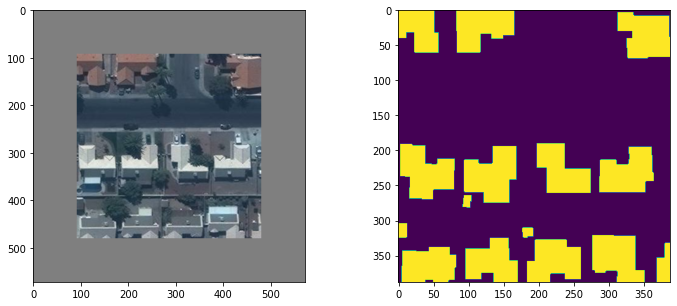

In [6]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
image, label = next(iter(train_ds))
ax[0].imshow(image / 2 + 0.5)
ax[1].imshow(np.argmax(label, axis=-1))

In [7]:
model = Unet()
model.build(input_shape=(None, 572, 572, 3))
model.summary()

Model: "unet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_block (InputBlock)     multiple                  38720     
_________________________________________________________________
bottleneck_block (Bottleneck multiple                  18876928  
_________________________________________________________________
output_block (OutputBlock)   multiple                  110850    
_________________________________________________________________
downsample_block (Downsample multiple                  221440    
_________________________________________________________________
downsample_block_1 (Downsamp multiple                  885248    
_________________________________________________________________
downsample_block_2 (Downsamp multiple                  3539968   
_________________________________________________________________
upsample_block (UpsampleBloc multiple                  8258816

In [8]:
def dice_coef(y_true, y_pred, eps=1e-6):
    axes = tf.range(1, tf.experimental.numpy.ndim(y_pred))
    intersection = tf.reduce_sum(y_true * y_pred, axis=axes)
    union = tf.reduce_sum(y_pred * y_pred + y_true * y_true, axis=axes)
    return tf.reduce_mean((2. * intersection + eps) / (union + eps), axis=0)

def ce_dice_loss(y_true, y_pred):
    batch_size = tf.shape(y_pred)[0]
    n_classes = tf.shape(y_pred)[-1]
    flat_logits = tf.reshape(tf.cast(y_pred, tf.float32), [batch_size, -1, n_classes])
    flat_labels = tf.reshape(tf.cast(y_true, tf.float32), [batch_size, -1, n_classes])
    flat_probs = tf.keras.activations.softmax(flat_logits)
    dice_loss = tf.reduce_mean(1 - dice_coef(flat_labels, flat_probs))
    ce_loss = tf.keras.losses.categorical_crossentropy(flat_labels, flat_probs)
    return ce_loss + dice_loss

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4, decay=1e-6),
              loss=ce_dice_loss,
              metrics=[dice_coef, 'categorical_accuracy'])

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

logdir = "../results/"
checkpoint = ModelCheckpoint(filepath='"../results/weights.{epoch:02d}-{val_loss:.2f}.h5',
                             monitor='val_dice_coef',
                             verbose=1,
                             save_best_only=False,
                             mode='max',
                             save_weights_only=True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef',
                                   factor=0.5, 
                                   patience=3, 
                                   verbose=1,
                                   mode='max',
                                   min_delta=0.0001,
                                   cooldown=2,
                                   min_lr=1e-6)
early = EarlyStopping(monitor='val_dice_coef', mode='max', patience=3)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq=100)
callbacks_list = [checkpoint, early, reduceLROnPlat, tensorboard_callback]

In [10]:
%reload_ext tensorboard
%tensorboard --bind_all --logdir ../results

In [11]:
loss_history = model.fit(train_ds.batch(BATCH_SIZE),
                         epochs=NUM_EPOCHS,
                         validation_data=val_ds.batch(BATCH_SIZE),
                         callbacks=callbacks_list)

Epoch 1/10
35093/35093 [==============================] - 14064s 398ms/step - loss: 0.2395 - dice_coef: 0.3671 - categorical_accuracy: 0.9267 - val_loss: 0.1257 - val_dice_coef: 0.2712 - val_categorical_accuracy: 0.9624

Epoch 00001: saving model to ../results/weights.01-0.13.h5
Epoch 2/10
35093/35093 [==============================] - 13879s 395ms/step - loss: 0.1127 - dice_coef: 0.2510 - categorical_accuracy: 0.9659 - val_loss: 0.0985 - val_dice_coef: 0.2471 - val_categorical_accuracy: 0.9699

Epoch 00002: saving model to ../results/weights.02-0.10.h5
Epoch 3/10
35093/35093 [==============================] - 13798s 393ms/step - loss: 0.0922 - dice_coef: 0.2249 - categorical_accuracy: 0.9715 - val_loss: 0.0845 - val_dice_coef: 0.2071 - val_categorical_accuracy: 0.9739

Epoch 00003: saving model to ../results/weights.03-0.08.h5
Epoch 4/10
35093/35093 [==============================] - 13781s 393ms/step - loss: 0.0789 - dice_coef: 0.1969 - categorical_accuracy: 0.9753 - val_loss: 0.0759

In [12]:
model.load_weights('../results/weights.04-0.08.h5')

In [13]:
def visualise_predictions(image, prediction, label):
    target_size = (300, 300)
    fig = plt.figure(figsize=(12, 12))
    ax = fig.subplots(2, 2)
    image = tf.image.central_crop(image, 388 / 572)
    image = tf.image.resize(image, target_size)
    image = tf.divide(tf.squeeze(image) + 1, 2)
    label = tf.image.resize(label, target_size)
    label = np.argmax(label, axis=-1)
    prediction = tf.image.resize(prediction, target_size)
    prediction_probs = tf.keras.activations.softmax(prediction)
    
    prediction = np.argmax(prediction, axis=-1)
    ax[1, 1].imshow(prediction_probs[:, :, 1].numpy().astype(np.float32))
    ax[1, 1].set_title('Prediction')
    prediction = morphology.binary_opening(prediction, morphology.disk(3))
    prediction = morphology.binary_closing(prediction, morphology.disk(3))
    prediction, num_labels = morphology.label(prediction, return_num=True)
    properties = measure.regionprops(prediction)
    ax[1, 0].imshow(prediction)
    ax[1, 0].set_title('Morphed')
    for num, props in enumerate(properties):
        y1, x1, y2, x2 = props.bbox
        p = matplotlib.patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1,
                                         alpha=0.7, linestyle="dashed",
                                         edgecolor='white', facecolor='none')
        ax[1, 0].add_patch(p)
    ax[0, 0].imshow(mark_boundaries(image, prediction))
    ax[0, 0].set_title('Image with morphed prediction')
    ax[0, 1].imshow(mark_boundaries(image, label))
    ax[0, 1].set_title('Image with label')

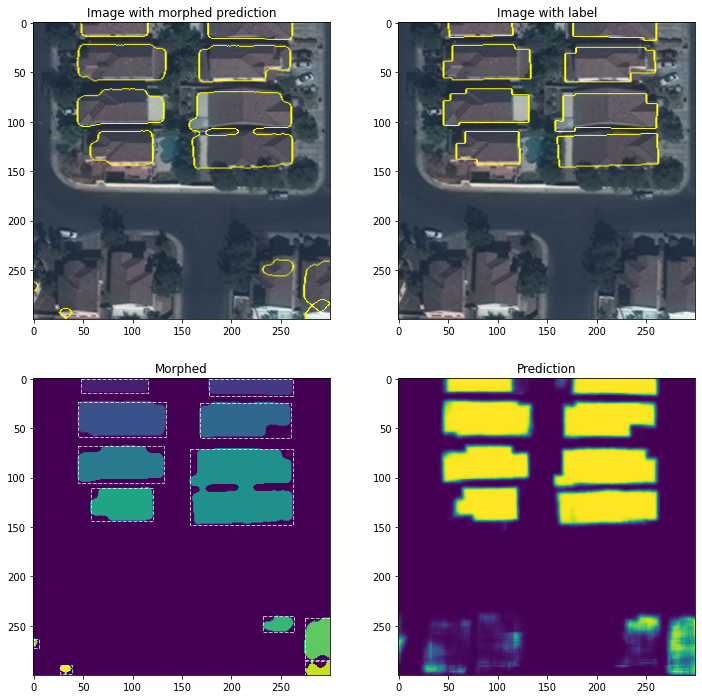

In [14]:
image_batch, label_batch = next(iter(train_ds.batch(1).skip(300)))
prediction_batch = model.predict(image_batch)
visualise_predictions(image_batch[0], prediction_batch[0], label_batch[0])

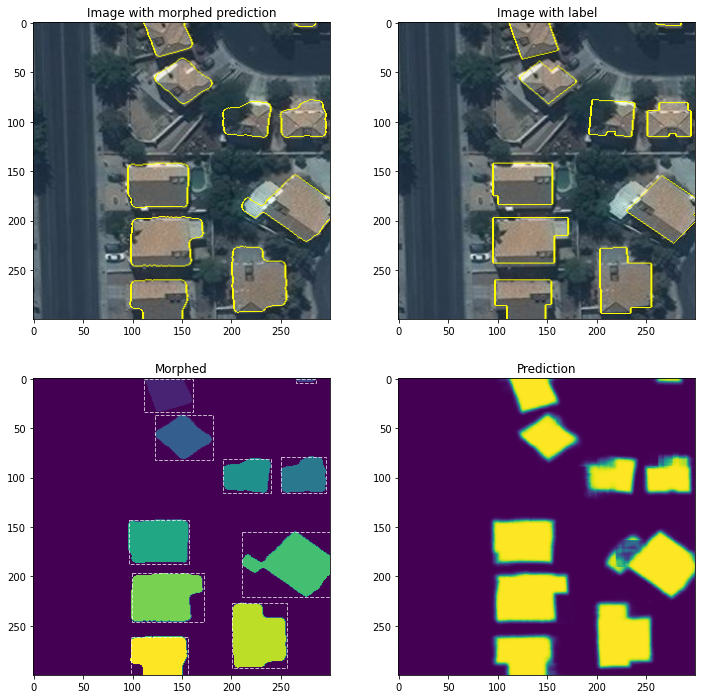

In [15]:
image_batch, label_batch = next(iter(val_ds.batch(1).skip(100)))
prediction_batch = model.predict(image_batch)
visualise_predictions(image_batch[0], prediction_batch[0], label_batch[0])

In [16]:
def get_submission_instances(prediction, image_id):
    submission_objects = []
    prediction = tf.image.resize(prediction, (300, 300))
    prediction_probs = tf.keras.activations.softmax(prediction)
    prediction_probs = np.ma.array(prediction_probs[:, :, 1].numpy())
    prediction = np.argmax(prediction, axis=-1)
    prediction = morphology.binary_opening(prediction, morphology.disk(3))
    prediction = morphology.binary_closing(prediction, morphology.disk(3))
    prediction, num_labels = morphology.label(prediction, return_num=True)
    properties = measure.regionprops(prediction)
    for num, props in enumerate(properties):
        prediction_probs.mask = prediction != num + 1
        segmentation_mask = (prediction == num + 1).astype(np.uint8)
        encoded_mask = mask.encode(np.asfortranarray(segmentation_mask))
        encoded_mask['counts'] = encoded_mask['counts'].decode('UTF-8')
        y1, x1, y2, x2 = props.bbox
        submission_objects.append({
            'image_id': image_id,
            'category_id': 100,
            'score': prediction_probs.mean(),
            'segmentation': encoded_mask,
            'bbox': [x1, y1, x2 - x1, y2 - y1]
        })
    return submission_objects

In [17]:
get_submission_instances(prediction_batch[0], 0)

[{'image_id': 0,
  'category_id': 100,
  'score': 0.9486865885959654,
  'segmentation': {'size': [300, 300],
   'counts': 'PjP12Z92N2N3M4L2N2N2N4L2N3M3M2N001O000000O1000000O10000O1000000O1000000O10000O1000001N5L2N2M3N2N2M3N3KbfX1'},
  'bbox': [112, 0, 49, 34]},
 {'image_id': 0,
  'category_id': 100,
  'score': 0.7743563265413851,
  'segmentation': {'size': [300, 300],
   'counts': '\\d]21[92N001O0000000000000000000000000000O100NZS4'},
  'bbox': [265, 0, 21, 4]},
 {'image_id': 0,
  'category_id': 100,
  'score': 0.9297470567960641,
  'segmentation': {'size': [300, 300],
   'counts': 'lRT12X94M2N2O0O2O1N2N2O1N2O0O2O0O2N2N2O1N2N2O1N2N2N2N2O1N101O0001O0O2O1N101N2N3N0O2N3M2O1N2N2N101N2N2O0O2O1N101N101N2N3LiiR1'},
  'bbox': [123, 37, 58, 45]},
 {'image_id': 0,
  'category_id': 100,
  'score': 0.9197145090731402,
  'segmentation': {'size': [300, 300],
   'counts': 'eZY2110V9d0@2M2O001N100000O100000O1000000O100N2N200O100O01000O100O101O000001O00000000001O002N5J3N2\\O^G4NJZ[1'},
  'bbox': [250, 